In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

/home/ic-lab/miniconda3/envs/torch_v1.9_gpu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
task_datasets = []

# Task 1
task1_data = np.load('./cwru1_X_train.npy')
task1_labels = np.load('./cwru2_y_train.npy')

# Task 2
task2_data = np.load('./cwru2_X_train.npy')
task2_labels = np.load('./cwru2_y_train.npy')

# Task 3
task3_data = np.load('./cwru3_X_train.npy')
task3_labels = np.load('./cwru3_y_train.npy')

# Task 4
task4_data = np.load('./cwru4_X_train.npy')
task4_labels = np.load('./cwru4_y_train.npy')

In [3]:
# Convert the data to PyTorch tensors
# Task 1
task1_data = torch.from_numpy(task1_data)
task1_labels = torch.from_numpy(task1_labels)

# Task 2
task2_data = torch.from_numpy(task2_data)
task2_labels = torch.from_numpy(task2_labels)

# Task 3
task3_data = torch.from_numpy(task3_data)
task3_labels = torch.from_numpy(task3_labels)

# Task 4
task4_data = torch.from_numpy(task4_data).double()
task4_labels = torch.from_numpy(task4_labels).double()

In [4]:
# data transpose
task1_data = task1_data.transpose(1, 2)
task2_data = task2_data.transpose(1, 2)
task3_data = task3_data.transpose(1, 2)
task4_data = task4_data.transpose(1, 2)

In [5]:
# dataset for task 1~4
dataset1 = torch.utils.data.TensorDataset(task1_data, task1_labels)
dataset2 = torch.utils.data.TensorDataset(task2_data, task2_labels)
dataset3 = torch.utils.data.TensorDataset(task3_data, task3_labels)
dataset4 = torch.utils.data.TensorDataset(task4_data, task4_labels)

In [6]:
# 划分训练集和测试集
train_size = int(0.8 * len(dataset1))
test_size = len(dataset1) - train_size

train_dataset1, test_dataset1 = random_split(dataset1, [train_size, test_size])
train_dataset2, test_dataset2 = random_split(dataset2, [train_size, test_size])
train_dataset3, test_dataset3 = random_split(dataset3, [train_size, test_size])
train_dataset4, test_dataset4 = random_split(dataset4, [train_size, test_size])

In [7]:
task_datasets.append((train_dataset1, test_dataset1))
task_datasets.append((train_dataset2, test_dataset2))
task_datasets.append((train_dataset3, test_dataset3))
task_datasets.append((train_dataset4, test_dataset4))

In [8]:
# 定义WDCNN模型
class WDCNN(nn.Module):
    def __init__(self, num_classes):
        super(WDCNN, self).__init__()
        self.conv1 = nn.Conv1d(2, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 256, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [14]:
# 创建WDCNN模型实例
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model and optimizers
model = WDCNN(num_classes=10).to(device)
model.double()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# training and testing
num_epochs = 10
task_accuracies = []

for i in range(4): # each task
    print(f"Training Task {i+1}")
    
    # Reset the parameter of model
    model.apply(lambda m: setattr(m, 'prev_weights', None))
    
    train_loader = torch.utils.data.DataLoader(task_datasets[i][0], batch_size=32, shuffle=True)
    
    # Set training set and test set of current task
    # train_subset_indices = range(i * 2000, (i+1) * 2000)
    # test_subset_indices = range(0, 14000) if i == 0 else range((i+1) * 2000, 14000)
    # train_subset = torch.utils.data.Subset(train_dataset, train_subset_indices)
    # test_subset = torch.utils.data.Subset(test_dataset, test_subset_indices)
    # train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    # test_loader = DataLoader(test_subset, batch_size=32, shuffle=True)
    
    # Training
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(device, dtype=torch.double)
            labels = labels.to(device, dtype=torch.long)
            
            # inputs = inputs.to(device)  # 移动到设备上
            # labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs ,labels)
            loss.backward()
            optimizer.step()
    
    model.eval()
    accuracies = []
    for j in range(4):
        # test_subset_indices = range(j * 2000, (j+1) * 2000)
        # test_subset = torch.utils.data.Subset(test_dataset, test_subset_indices)
        test_loader = torch.utils.data.DataLoader(task_datasets[j][1], batch_size=32, shuffle=False)
        total = 0
        correct = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device, dtype=torch.double)
            labels = labels.to(device, dtype=torch.long)
            
            # inputs = inputs.to(device)  # 移动到设备上
            # labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        
    task_accuracies.append(accuracies)

Training Task 1
Training Task 2
Training Task 3
Training Task 4


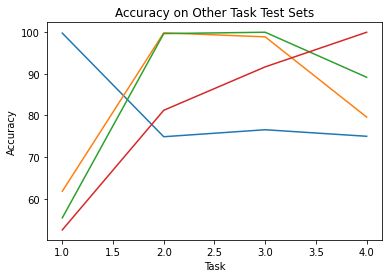

In [15]:
# 
x = range(1, 5)
plt.plot(x, task_accuracies)
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.title('Accuracy on Other Task Test Sets')
plt.show()

In [16]:
print(task_accuracies)

[[99.78571428571429, 61.785714285714285, 55.392857142857146, 52.5], [74.89285714285714, 99.85714285714286, 99.67857142857143, 81.25], [76.57142857142857, 98.89285714285714, 100.0, 91.67857142857143], [75.0, 79.60714285714286, 89.17857142857143, 100.0]]
